In [232]:
%reset
'''
https://www.kaggle.com/ardamavi/sign-language-digits-dataset/home

Sign languages (also known as signed languages) are languages that use manual communication to convey meaning. 
This can include simultaneously employing hand gestures, movement, orientation of the fingers, 
arms or body, and facial expressions to convey a speaker's ideas. 
Source: https://en.wikipedia.org/wiki/Sign_language

This is classification task.
'''

"\nhttps://www.kaggle.com/ardamavi/sign-language-digits-dataset/home\n\nSign languages (also known as signed languages) are languages that use manual communication to convey meaning. \nThis can include simultaneously employing hand gestures, movement, orientation of the fingers, \narms or body, and facial expressions to convey a speaker's ideas. \nSource: https://en.wikipedia.org/wiki/Sign_language\n\nThis is classification task.\n"

In [233]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [234]:
IMAGE_SIZE = 64

def load_data_raw():
    X = np.load('X.npy')
    Y = np.load('Y.npy')
    return X, Y

X_raw, Y_raw = load_data_raw()
print('X shape: {}'.format(X_raw.shape))
print('Y shape: {}'.format(Y_raw.shape))

X shape: (2062, 64, 64)
Y shape: (2062, 10)


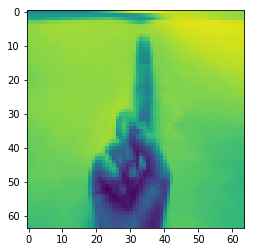

In [235]:
# Show sample data.
plt.imshow(X_raw[1027].reshape(IMAGE_SIZE, IMAGE_SIZE))

# Binary classification (logistic regression)

In [192]:
def transform_binary_raw(X_raw, Y_raw):
    X_binary = np.concatenate((X_raw[204:409], X_raw[822:1027]), axis=0)  # Takes only zero and one signs.
    # Preapare new Y vector.
    z = np.zeros(205)
    o = np.ones(205)
    Y_binary = np.concatenate((z, o), axis=0).reshape(X_binary.shape[0], 1)
    return X_binary, Y_binary

X_binary, Y_binary = transform_binary_raw(X_raw, Y_raw)
print('X shape: {}'.format(X_binary.shape))
print('Y shape: {}'.format(Y_binary.shape))

X shape: (410, 64, 64)
Y shape: (410, 1)


In [193]:
# Train-test split.
X_train, X_test, Y_train, Y_test = train_test_split(X_binary, Y_binary, test_size=0.15, random_state=100)

Cost after iteration 0: 14.250517836240071
Cost after iteration 50: 6.81481399848281
Cost after iteration 100: 0.7231131289371734
Cost after iteration 150: 0.2108473718442654
Cost after iteration 200: 0.16157861189413905
Cost after iteration 250: 0.13165022517204045
Cost after iteration 300: 0.11231496141522976
Cost after iteration 350: 0.09850629809430675
Cost after iteration 400: 0.08788266100295936
Cost after iteration 450: 0.07931010971488991
Cost after iteration 500: 0.07219399493913004
Cost after iteration 550: 0.06619006132705059
Cost after iteration 600: 0.06107399746601222
Cost after iteration 650: 0.05668323347777297
Cost after iteration 700: 0.05289152736665596
Cost after iteration 750: 0.04959756745241712
Cost after iteration 800: 0.046719040914108376
Cost after iteration 850: 0.04418874748208771
Cost after iteration 900: 0.041951629538302906
Cost after iteration 950: 0.03996240307490106
Cost after iteration 1000: 0.038183675163349126
------------------------------------
Tr

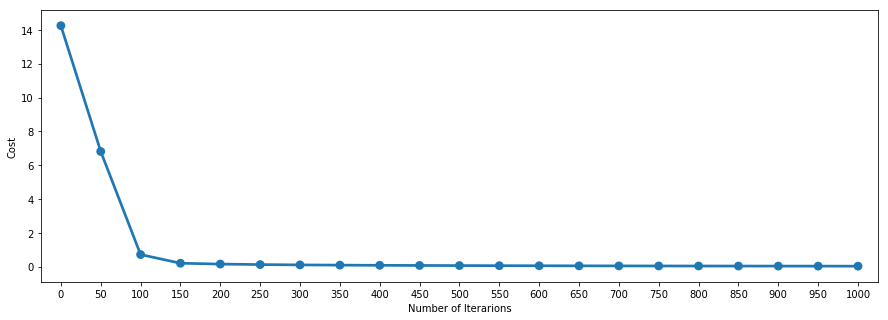

In [182]:
%%time
LEARNING_RATE = 0.03
NUMBER_OF_ITERATIONS = 1001

def preprocessing_binary(df):
    # Reshape (make 2D).
    df = df.reshape(df.shape[0], IMAGE_SIZE * IMAGE_SIZE)
    # Transpose.
    df = df.T
    return df    
    
X_train = preprocessing_binary(X_train)
X_test = preprocessing_binary(X_test)

# Labels transpose.
Y_train = Y_train.T
Y_test = Y_test.T

# In forward propagation
# z = (w.T)x + b => x is pixel array, w are weights and b is bias. T is transpose

# Gradient descent.
# Take derivative of cost function according to weight and bias.
# Then multiply it with α learning rate. Then update weight.

# Initial parameters
def get_initial_parameters():
    # weight = np.random.random(IMAGE_SIZE * IMAGE_SIZE) / 10
    weight = np.full((IMAGE_SIZE * IMAGE_SIZE, 1), 0.01)
    bias = 0.1
    return weight, bias

def sigmoid(z):
    y_head = 1 / (1 + np.exp(-z))
    return y_head

def log_loss(y_train, y_head):
    return -y_train * np.log(y_head) - (1 - y_train) * np.log(1 - y_head)

def forward_backward_propagation(weight, bias, X_train, Y_train):
    # Forward propagation.
    z = np.dot(weight.T, X_train) + bias
    Y_head = sigmoid(z)
    loss = log_loss(Y_train, Y_head)
    cost = (np.sum(loss)) / X_train.shape[1]
    
    # Backward propagation.
    # x_train.shape[1] is for scaling
    derivative_weight = (np.dot(X_train, ((Y_head - Y_train).T))) / X_train.shape[1]
    derivative_bias = np.sum(Y_head - Y_train) / X_train.shape[1]
    gradients = {'derivative_weight': derivative_weight, 'derivative_bias': derivative_bias}
    return cost, gradients
    
def update(weight, bias, X_train, Y_train, learning_rate, number_of_iterarions):
    cost_all = []
    for_viz = []
    
    for i in range(number_of_iterarions):
        cost, gradients = forward_backward_propagation(
            weight, bias, X_train,Y_train)
        cost_all.append(cost)
        # Update.
        weight = weight - learning_rate * gradients['derivative_weight']
        bias = bias - learning_rate * gradients['derivative_bias']
        if i % 50 == 0:
            for_viz.append((i, cost))
            print('Cost after iteration {}: {}'.format(i, cost))
        
    parameters = {'weight': weight, 'bias': bias}
    return parameters, gradients, cost_all, for_viz

def predict(weight, bias, X_test):
    # Forward propagation with defined weights and biases.
    z = sigmoid(np.dot(weight.T, X_test) + bias)
    Y_prediction = np.zeros((1, X_test.shape[1]))
    # If z is bigger than 0.5, our prediction is sign one (y_head=1),
    # If z is smaller than 0.5, our prediction is sign zero (y_head=0),
    for i in range(z.shape[1]):
        if z[0, i] <= 0.5:
            Y_prediction[0, i] = 0
        else:
            Y_prediction[0, i] = 1
    return Y_prediction

def logistic_regression(
    X_train, Y_train, X_test, Y_test, learning_rate, number_of_iterarions):
    
    weight, bias = get_initial_parameters()
    
    parameters, gradients, cost_list, for_viz = update(
        weight, bias, X_train, Y_train, learning_rate, number_of_iterarions)
    
    Y_prediction_train = predict(parameters['weight'], parameters['bias'], X_train)
    Y_prediction_test = predict(parameters['weight'], parameters['bias'], X_test)
    return Y_train, Y_prediction_train, Y_test, Y_prediction_test, for_viz

def evaluation(Y_train, Y_prediction_train, Y_test, Y_prediction_test, for_viz):
    print('------------------------------------')
    print('Train accuracy: {} %'.format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print('Test accuracy: {} %'.format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    print('------------------------------------')
    
    plt.figure(figsize=(15, 5))
    sns.pointplot(x='index', y='cost', data=pd.DataFrame(for_viz, columns=['index', 'cost']))
    plt.xlabel('Number of Iterarions')
    plt.ylabel('Cost')
    
# RUN.
Y_train, Y_prediction_train, Y_test, Y_prediction_test, for_viz = logistic_regression(
    X_train, Y_train, X_test, Y_test, LEARNING_RATE, NUMBER_OF_ITERATIONS)
evaluation(Y_train, Y_prediction_train, Y_test, Y_prediction_test, for_viz)

# Multiclass classification (Neural network)